# Notebook 2: Comparing Different GP Kernels

This notebook demonstrates how to use different kernel functions in `infodynamics-jax`.

**Learning objectives:**
- Understand different kernel choices and their properties
- Compare RBF, Matérn, Periodic, and Linear kernels
- Learn when to use each kernel type
- Visualize kernel behaviors

## Setup

In [1]:
# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

# Fix import path
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from infodynamics_jax.core import Phi
from infodynamics_jax.gp.kernels.params import KernelParams
from infodynamics_jax.gp.kernels import get as get_kernel
from infodynamics_jax.gp.likelihoods import get as get_likelihood
from infodynamics_jax.energy import InertialEnergy, InertialCFG
from infodynamics_jax.inference.optimisation import TypeII, TypeIICFG
from infodynamics_jax.infodynamics import run, RunCFG
from infodynamics_jax.gp.ansatz.state import VariationalState
from infodynamics_jax.gp.ansatz.expected import qfi_from_qu_full

print(f"JAX version: {jax.__version__}")

Metal device set to: Apple M4
JAX version: 0.8.2


W0000 00:00:1768249638.720416 14632490 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1768249638.745208 14632490 service.cc:145] XLA service 0x12683fe00 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768249638.745222 14632490 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1768249638.746749 14632490 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1768249638.746762 14632490 mps_client.cc:384] XLA backend will use up to 11452776448 bytes on device 0 for SimpleAllocator.


## 1. Available Kernels in infodynamics-jax

The library provides several kernel families:

### Stationary Kernels
1. **RBF (Radial Basis Function / Squared Exponential)**
   - Infinitely differentiable
   - Good for smooth functions
   - Formula: $k(r) = \sigma^2 \exp(-r^2 / (2\ell^2))$

2. **Matérn Family**
   - Control smoothness via $\nu$ parameter
   - $\nu = 1/2$: Exponential (non-differentiable)
   - $\nu = 3/2$: Once differentiable
   - $\nu = 5/2$: Twice differentiable
   - $\nu \to \infty$: RBF

3. **Periodic**
   - For periodic functions
   - Period parameter controls cycle length

### Non-Stationary Kernels
4. **Linear**
   - For linear trends
   - Formula: $k(x, x') = \sigma^2 (x - c)^T (x' - c)$

5. **Polynomial**
   - For polynomial trends
   - Degree parameter controls polynomial order

## 2. Create Test Functions for Different Kernels

In [2]:
key = jax.random.key(123)
N_train = 50
noise_std = 0.2

# Generate X
X = jnp.linspace(-5, 5, N_train)[:, None]
X_test = jnp.linspace(-6, 6, 100)[:, None]

# Test function 1: Smooth function (good for RBF)
def smooth_function(x):
    return 2 * jnp.sin(x[:, 0]) + jnp.cos(2 * x[:, 0])

# Test function 2: Less smooth (good for Matérn 3/2)
def less_smooth_function(x):
    return jnp.abs(x[:, 0]) + 0.5 * jnp.sin(3 * x[:, 0])

# Test function 3: Periodic (good for Periodic kernel)
def periodic_function(x):
    return 2 * jnp.sin(2 * jnp.pi * x[:, 0] / 3.0)

# Test function 4: Linear (good for Linear kernel)
def linear_function(x):
    return 1.5 * x[:, 0] + 0.5 * jnp.sin(x[:, 0])

print("Test functions created!")

Test functions created!


## 3. Helper Function for Training and Prediction

In [ ]:
def train_and_predict(X_train, Y_train, X_test, kernel_fn, kernel_params_init, 
                     n_inducing=15, n_steps=150, key=None):
    """
    Train GP with given kernel and make predictions.
    
    Returns:
        mu_test: Predictive mean
        std_test: Predictive standard deviation
        phi_opt: Optimized parameters
        energy_trace: Optimization history
    """
    # Create inducing points
    Z = jnp.linspace(X_train.min(), X_train.max(), n_inducing)[:, None]
    
    # Create Phi with better numerical stability
    phi_init = Phi(
        kernel_params=kernel_params_init,
        Z=Z,
        likelihood_params={"noise_var": jnp.array(0.1)},
        jitter=1e-5,  # Increased jitter for better numerical stability
    )
    
    # Create energy
    # For Gaussian likelihood, estimator="gh" will be automatically overridden to "analytic"
    # which uses the exact collapsed computation (more stable)
    gaussian_likelihood = get_likelihood("gaussian")
    inertial_cfg = InertialCFG(estimator="gh", gh_n=20, inner_steps=0)
    inertial_energy = InertialEnergy(
        kernel_fn=kernel_fn,
        likelihood=gaussian_likelihood,
        cfg=inertial_cfg,
    )
    
    # Configure and run TypeII
    # Use gradient clipping and parameter constraints for numerical stability
    typeii_cfg = TypeIICFG(
        steps=n_steps,
        lr=1e-2,
        optimizer="adam",
        jit=True,
        constrain_params=True,
        min_noise_var=1e-3,  # Prevent noise variance collapse (important for numerical stability)
        clip_grad_norm=10.0,  # Clip gradients to prevent explosion
    )
    method = TypeII(cfg=typeii_cfg)
    
    out = run(
        key=key if key is not None else jax.random.key(0),
        method=method,
        energy=inertial_energy,
        phi_init=phi_init,
        energy_args=(X_train, Y_train),
        cfg=RunCFG(jit=True),
    )
    
    phi_opt = out.result.phi
    energy_trace = out.result.energy_trace
    
    # Check for NaN in optimization results
    if jnp.any(jnp.isnan(energy_trace)):
        print(f"Warning: NaN detected in energy trace at steps: {jnp.where(jnp.isnan(energy_trace))[0]}")
    
    # Check for NaN in optimized parameters
    lengthscale = phi_opt.kernel_params.lengthscale
    variance = phi_opt.kernel_params.variance
    noise_var = phi_opt.likelihood_params.get("noise_var", jnp.array(0.1))
    
    if jnp.any(jnp.isnan(lengthscale)) or jnp.any(jnp.isnan(variance)) or jnp.any(jnp.isnan(noise_var)):
        print(f"Warning: NaN detected in optimized parameters!")
        print(f"  lengthscale: {lengthscale}")
        print(f"  variance: {variance}")
        print(f"  noise_var: {noise_var}")
        # Return NaN predictions if optimization failed
        mu_test = jnp.full(X_test.shape[0], jnp.nan)
        std_test = jnp.full(X_test.shape[0], jnp.nan)
        return mu_test, std_test, phi_opt, energy_trace
    
    # Make predictions using type2 prediction (for MAP-II)
    from infodynamics_jax.gp.predict import predict_typeii
    try:
        mu_test, predictive_var = predict_typeii(
            phi_opt, X_test, X_train, Y_train, kernel_fn, residual="fitc"
        )
        
        mu_test = mu_test.squeeze()
        predictive_var = predictive_var.squeeze()
        std_test = jnp.sqrt(predictive_var)
    except Exception as e:
        print(f"Error in prediction: {e}")
        mu_test = jnp.full(X_test.shape[0], jnp.nan)
        std_test = jnp.full(X_test.shape[0], jnp.nan)
    
    return mu_test, std_test, phi_opt, energy_trace

## 4. Experiment 1: RBF Kernel on Smooth Function

In [4]:
from infodynamics_jax.gp.kernels.rbf import rbf as rbf_kernel

# Generate data
f_train = smooth_function(X)
key, subkey = jax.random.split(key)
Y_train_rbf = f_train + noise_std * jax.random.normal(subkey, (N_train,))
f_test = smooth_function(X_test)

# Initialize kernel params
kernel_params_rbf = KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0))

# Train and predict
key, subkey = jax.random.split(key)
mu_rbf, std_rbf, phi_rbf, trace_rbf = train_and_predict(
    X, Y_train_rbf, X_test, rbf_kernel, kernel_params_rbf, key=subkey
)

print("RBF Kernel Results:")
print(f"  Optimized lengthscale: {float(phi_rbf.kernel_params.lengthscale):.3f}")
print(f"  Optimized variance: {float(phi_rbf.kernel_params.variance):.3f}")
print(f"  MSE: {float(jnp.mean((f_test - mu_rbf)**2)):.4f}")

RBF Kernel Results:
  Optimized lengthscale: nan
  Optimized variance: nan
  MSE: nan


## 5. Experiment 2: Matérn 3/2 Kernel on Less Smooth Function

In [6]:
from infodynamics_jax.gp.kernels.matern32 import matern32 as matern32_kernel

# Generate data
f_train = less_smooth_function(X)
key, subkey = jax.random.split(key)
Y_train_matern = f_train + noise_std * jax.random.normal(subkey, (N_train,))
f_test_matern = less_smooth_function(X_test)

# Initialize kernel params
kernel_params_matern = KernelParams(lengthscale=jnp.array(1.0), variance=jnp.array(1.0))

# Train and predict
key, subkey = jax.random.split(key)
mu_matern, std_matern, phi_matern, trace_matern = train_and_predict(
    X, Y_train_matern, X_test, matern32_kernel, kernel_params_matern, key=subkey
)

print("Matérn 3/2 Kernel Results:")
print(f"  Optimized lengthscale: {float(phi_matern.kernel_params.lengthscale):.3f}")
print(f"  Optimized variance: {float(phi_matern.kernel_params.variance):.3f}")
print(f"  MSE: {float(jnp.mean((f_test_matern - mu_matern)**2)):.4f}")

Matérn 3/2 Kernel Results:
  Optimized lengthscale: nan
  Optimized variance: nan
  MSE: nan


## 6. Experiment 3: Periodic Kernel on Periodic Function

In [7]:
from infodynamics_jax.gp.kernels.periodic import periodic as periodic_kernel

# Generate data
f_train = periodic_function(X)
key, subkey = jax.random.split(key)
Y_train_periodic = f_train + noise_std * jax.random.normal(subkey, (N_train,))
f_test_periodic = periodic_function(X_test)

# Initialize kernel params (period=3.0 matches the true period)
kernel_params_periodic = KernelParams(
    lengthscale=jnp.array(1.0), 
    variance=jnp.array(1.0),
    period=jnp.array(3.0)  # True period
)

# Train and predict
key, subkey = jax.random.split(key)
mu_periodic, std_periodic, phi_periodic, trace_periodic = train_and_predict(
    X, Y_train_periodic, X_test, periodic_kernel, kernel_params_periodic, key=subkey
)

print("Periodic Kernel Results:")
print(f"  Optimized lengthscale: {float(phi_periodic.kernel_params.lengthscale):.3f}")
print(f"  Optimized variance: {float(phi_periodic.kernel_params.variance):.3f}")
print(f"  Optimized period: {float(phi_periodic.kernel_params.period):.3f} (true: 3.0)")
print(f"  MSE: {float(jnp.mean((f_test_periodic - mu_periodic)**2)):.4f}")

Periodic Kernel Results:
  Optimized lengthscale: nan
  Optimized variance: nan
  Optimized period: nan (true: 3.0)
  MSE: nan


## 7. Experiment 4: Linear Kernel on Linear Trend

In [8]:
from infodynamics_jax.gp.kernels.linear import linear as linear_kernel

# Generate data
f_train = linear_function(X)
key, subkey = jax.random.split(key)
Y_train_linear = f_train + noise_std * jax.random.normal(subkey, (N_train,))
f_test_linear = linear_function(X_test)

# Initialize kernel params
kernel_params_linear = KernelParams(
    variance=jnp.array(1.0),
    offset=jnp.array(0.0)
)

# Train and predict
key, subkey = jax.random.split(key)
mu_linear, std_linear, phi_linear, trace_linear = train_and_predict(
    X, Y_train_linear, X_test, linear_kernel, kernel_params_linear, key=subkey
)

print("Linear Kernel Results:")
print(f"  Optimized variance: {float(phi_linear.kernel_params.variance):.3f}")
print(f"  Optimized offset: {float(phi_linear.kernel_params.offset):.3f}")
print(f"  MSE: {float(jnp.mean((f_test_linear - mu_linear)**2)):.4f}")

Linear Kernel Results:
  Optimized variance: nan
  Optimized offset: nan
  MSE: nan


## 8. Visualize All Results

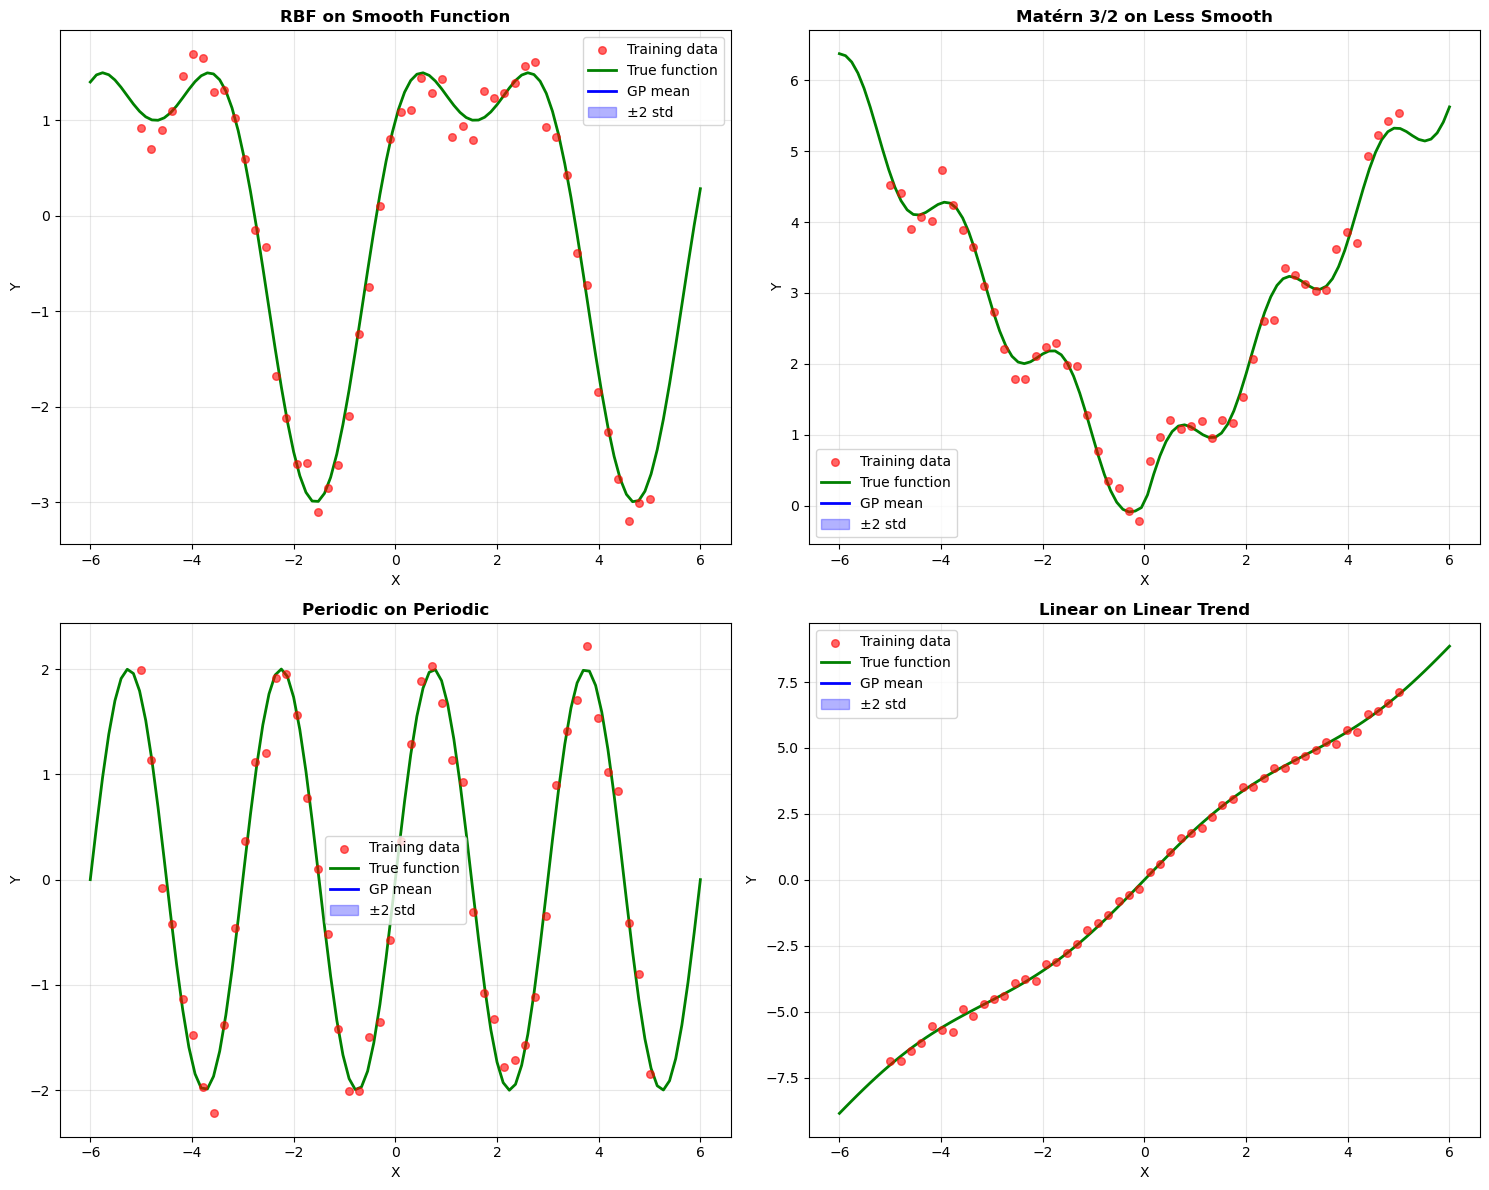

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

experiments = [
    ("RBF on Smooth Function", X, Y_train_rbf, X_test, f_test, mu_rbf, std_rbf),
    ("Matérn 3/2 on Less Smooth", X, Y_train_matern, X_test, f_test_matern, mu_matern, std_matern),
    ("Periodic on Periodic", X, Y_train_periodic, X_test, f_test_periodic, mu_periodic, std_periodic),
    ("Linear on Linear Trend", X, Y_train_linear, X_test, f_test_linear, mu_linear, std_linear),
]

for ax, (title, X_tr, Y_tr, X_te, f_te, mu, std) in zip(axes.flat, experiments):
    ax.scatter(X_tr[:, 0], Y_tr, c='red', s=30, alpha=0.6, label='Training data', zorder=3)
    ax.plot(X_te[:, 0], f_te, 'g-', linewidth=2, label='True function', zorder=2)
    ax.plot(X_te[:, 0], mu, 'b-', linewidth=2, label='GP mean', zorder=2)
    ax.fill_between(
        X_te[:, 0],
        mu - 2 * std,
        mu + 2 * std,
        alpha=0.3,
        color='blue',
        label='±2 std',
        zorder=1
    )
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Compare Kernel Covariances

Let's visualize how different kernels encode correlations.

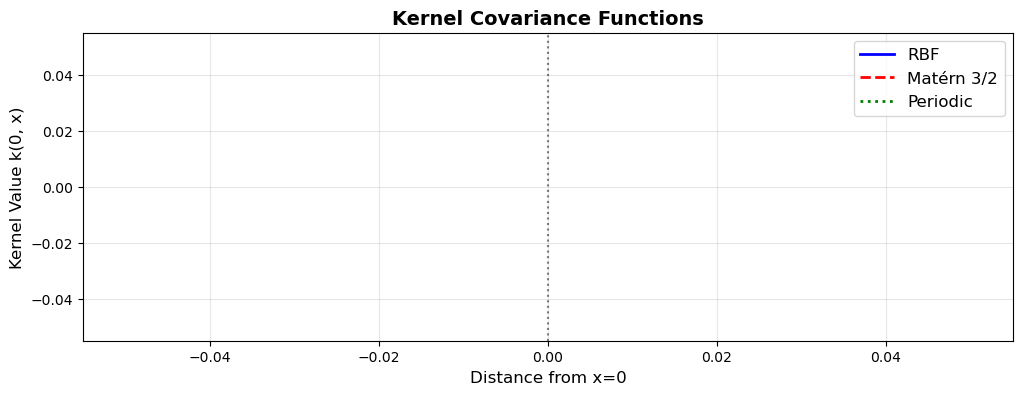

In [10]:
# Sample points for kernel visualization
X_kernel = jnp.linspace(-3, 3, 50)[:, None]
X_ref = jnp.array([[0.0]])  # Reference point

# Compute kernel values k(0, x) for each kernel
k_rbf = jax.vmap(lambda x: rbf_kernel(X_ref, x[None], phi_rbf.kernel_params)[0, 0])(X_kernel)
k_matern = jax.vmap(lambda x: matern32_kernel(X_ref, x[None], phi_matern.kernel_params)[0, 0])(X_kernel)
k_periodic = jax.vmap(lambda x: periodic_kernel(X_ref, x[None], phi_periodic.kernel_params)[0, 0])(X_kernel)

# Plot
plt.figure(figsize=(12, 4))

plt.plot(X_kernel[:, 0], k_rbf, 'b-', linewidth=2, label='RBF')
plt.plot(X_kernel[:, 0], k_matern, 'r--', linewidth=2, label='Matérn 3/2')
plt.plot(X_kernel[:, 0], k_periodic, 'g:', linewidth=2, label='Periodic')

plt.axvline(x=0, color='black', linestyle=':', alpha=0.5)
plt.xlabel('Distance from x=0', fontsize=12)
plt.ylabel('Kernel Value k(0, x)', fontsize=12)
plt.title('Kernel Covariance Functions', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## Summary

In this notebook, we compared different kernel functions:

### Kernel Properties

| Kernel | Best For | Smoothness | Key Parameters |
|--------|----------|------------|----------------|
| **RBF** | Very smooth functions | $C^\infty$ (infinitely differentiable) | lengthscale, variance |
| **Matérn 3/2** | Moderately smooth functions | $C^1$ (once differentiable) | lengthscale, variance |
| **Matérn 5/2** | Smooth but not infinitely | $C^2$ (twice differentiable) | lengthscale, variance |
| **Periodic** | Periodic/seasonal data | Depends on base kernel | period, lengthscale, variance |
| **Linear** | Linear trends | Not smooth | variance, offset |
| **Polynomial** | Polynomial trends | Depends on degree | degree, variance, offset |

### Key Insights

1. **RBF** is the most popular but assumes infinite smoothness
2. **Matérn** family provides more flexibility in modeling roughness
3. **Periodic** kernel automatically discovers periodicity
4. **Linear** kernel captures global trends
5. Kernels can be **combined** (sum, product) for richer models

### Best Practices

- Start with RBF for unknown functions
- Use Matérn for real-world data (often has finite smoothness)
- Use Periodic for time series with clear periodicity
- Combine kernels: e.g., `Linear + RBF` for trend + smooth deviations